# Second Harmonic Generation
---

$$
A_{2\omega}(\omega) = \frac{i\omega_{0} \chi^{(2)} L}{n_{2\omega} c}G_{m} F(\omega)  \Phi'(\omega)
$$

In [52]:
import sys
sys.path.append('../..') # Asegúrate de que Python pueda encontrar el paquete src

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from src.physics.pulses import GaussianPulse1D, format_value
from src.physics.crystals import KTPCrystal, KTPCrystal_Kato
from src.physics.nonlinear_optics import PhaseMatching
from src.physics.math import conv_discrete

# plt.style.use(['science', 'notebook'])
plt.style.use('dark_background')

### Set up initial parameters
---

In [68]:
# cavity length
L = 4e-3  # (m) | 4 mm

# Gaussian input pulse parameters
# Input beam parameters
input_width_wl = 44e-9             # (m) wl: wavelength FWHM
fundamental_wavelength = 795e-9    # (m) central wavelenght
fundamental_wavelength_um = fundamental_wavelength * 1e6  # (um) | 0.795 um

input_pulse = GaussianPulse1D(x0=fundamental_wavelength, FWHM=input_width_wl, steps=500)
wavelenght, y_wavelenght = input_pulse.generate_intensity()
sigma_wavelength = input_pulse.standard_deviation()  # (m) | 1.87e-08 m


# --------------- Parameters in frequency ---------------
c = 299792458  # (m/s)
fundamental_frequency = (2*np.pi*c) / fundamental_wavelength  # (Hz = 1/s) | 23.69 PHz
sigma_frequency = (2*np.pi*c) / (fundamental_wavelength**2) * sigma_wavelength  # (Hz) | 55.69 PHz

input_pulse_omega = GaussianPulse1D(x0=fundamental_frequency, steps=10000, std=sigma_frequency, times_std=8)
frequencies, A_omega = input_pulse_omega.generate_pulse()
frequencies, I_omega = input_pulse_omega.generate_intensity()

# --------------- SHG parameters ---------------
SHG_frequencies = 2 * frequencies  # Second harmonic frequencies
SHG_wavelength = fundamental_wavelength / 2  # Second harmonic wavelength (m)
SHG_wavelength_um = SHG_wavelength * 1e6  # Second harmonic wavelength (um) | 0.3975 um

print("Parameters of the Gaussian pulse in wavelength domain:")
print("-"*60)
# Obtener el diccionario con los parámetros del pulso
pulse_dict = input_pulse.as_dict()
for key, value in pulse_dict.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")
    
print("\n")
print("Parameters of the Gaussian pulse in frequency domain:")
print("-"*60)
# Obtener el diccionario con los parámetros del pulso
pulse_dict_omega = input_pulse_omega.as_dict()
for key, value in pulse_dict_omega.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

Parameters of the Gaussian pulse in wavelength domain:
------------------------------------------------------------
Center: 7.95e-07
Fwhm: 4.40e-08
Sigma: 1.87e-08
Steps: 500
Times Std: 5
Computed Fwhm: 4.38e-08


Parameters of the Gaussian pulse in frequency domain:
------------------------------------------------------------
Center: 2.37e+15
Fwhm: None
Sigma: 5.57e+13
Steps: 10000
Times Std: 8
Computed Fwhm: 1.31e+14


In [ ]:
fig0, axs0 = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica (a): Pulso de entrada vs omega
axs0[0].plot(omega*1e-15, A_omega, color='red', linestyle='-')
axs0[0].set_ylabel('Intensity, |F(ω)|²')
axs0[0].set_xlabel('Frequency ω (PHz)')
axs0[0].set_title('Input pulse')
# Agregar texto en la gráfica (b)
axs0[0].text(0.83, 0.8, r"$\omega_0 = 2.37$ PHz", ha='center', va='center', transform=axs[0].transAxes, fontsize=10)
axs0[0].text(0.8, 0.75, r"FWHM = 1.31 PHz", ha='center', va='center', transform=axs[0].transAxes, fontsize=10)

# Gráfica (a): Pulso de entrada vs longitud de onda
axs0[1].plot(wavelenght*1e9, y_wavelenght, color='red', linestyle='-')
axs0[1].set_ylabel('Intensity,|F(λ)|²')
axs0[1].set_xlabel('wavelength, λ (nm)')
axs0[1].set_title('Input pulse')

# Agregar texto en la gráfica (b)
axs0[1].text(0.83, 0.8, r"$\lambda_0 = 795$ nm", ha='center', va='center', transform=axs[1].transAxes, fontsize=10)
axs0[1].text(0.8, 0.75, r"FWHM = 44 nm", ha='center', va='center', transform=axs[1].transAxes, fontsize=10)

### Phase matching function
---

In [54]:
# instance of the crystal and phase matching
ktp = KTPCrystal()
phase_matching = PhaseMatching(ktp, lambda_0_um=fundamental_wavelength_um )

# IMPORTANT: frequencies must be the ones for the SHG
delta_k = phase_matching.phase_mismatch(SHG_frequencies)
phi = phase_matching.phase_matching_function(delta_k, L)

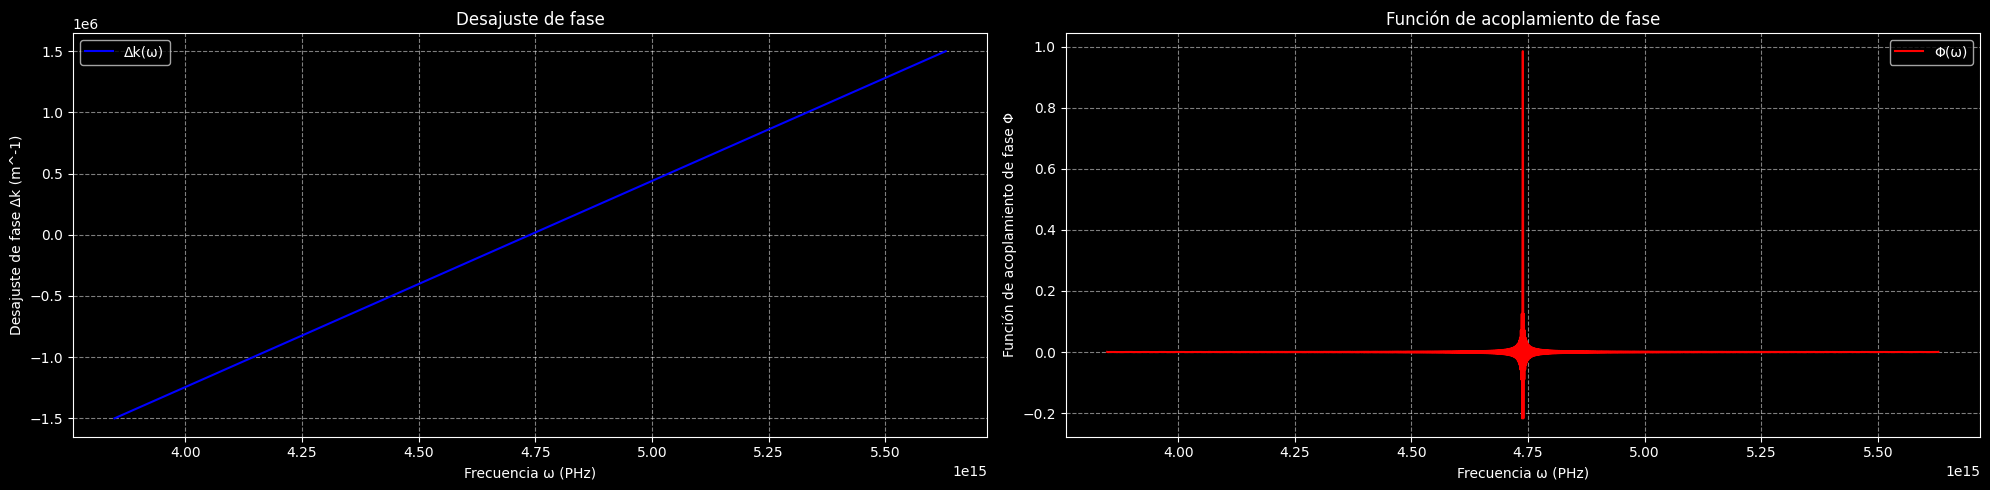

In [55]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(SHG_frequencies, delta_k, label='Δk(ω)', color='b')
plt.xlabel('Frecuencia ω (PHz)')
plt.ylabel('Desajuste de fase Δk (m^-1)')
plt.title('Desajuste de fase')
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend()
plt.subplot(1, 2, 2)

plt.plot(SHG_frequencies, phi, label='Φ(ω)', color='r')
plt.xlabel('Frecuencia ω (PHz)')
plt.ylabel('Función de acoplamiento de fase Φ')
plt.title('Función de acoplamiento de fase')
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig('phase_mismatch_and_matching.png')

plt.show()

### Self-convolution of the initial pulse
---

In [56]:
# Discrete convolution
conv_result = conv_discrete(A_omega, A_omega, frequencies)  # self-convolution

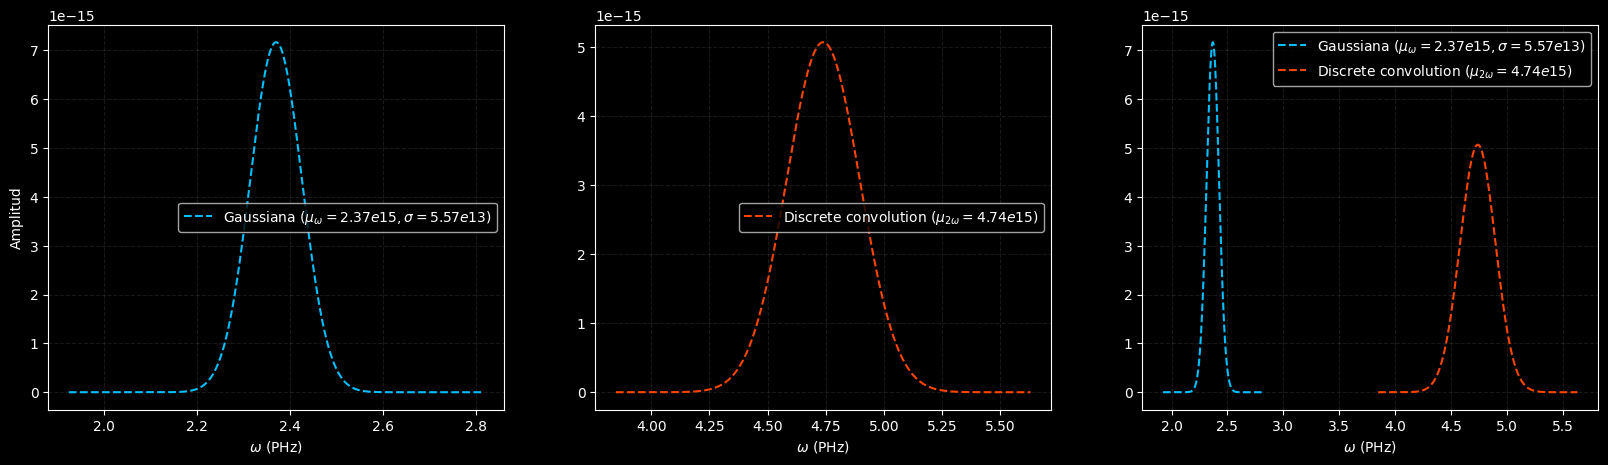

In [57]:
# --- Visualización Comparativa entrada y salida---
fig1, axs = plt.subplots(1,3,figsize=(20,5))

axs[0].plot(frequencies*1e-15, A_omega, label=r'Gaussiana ($\mu_{\omega}=2.37e15, \sigma=5.57e13$)', linestyle='--', color='deepskyblue')
axs[0].set_xlabel(r'$\omega$ (PHz)')
axs[0].set_ylabel('Amplitud')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.1)

axs[1].plot(SHG_frequencies*1e-15, conv_result, label=r'Discrete convolution ($\mu_{2\omega}=4.74e15$)', linestyle='--', color='orangered')
axs[1].set_xlabel(r'$\omega$ (PHz)')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.1)

axs[2].plot(frequencies*1e-15, A_omega, label=r'Gaussiana ($\mu_{\omega}=2.37e15, \sigma=5.57e13$)', linestyle='--', color='deepskyblue')
axs[2].plot(SHG_frequencies*1e-15, conv_result, label=r'Discrete convolution ($\mu_{2\omega}=4.74e15$)', linestyle='--', color='orangered')
axs[2].set_xlabel(r'$\omega$ (PHz)')
axs[2].legend()
axs[2].grid(True, linestyle='--', alpha=0.1)

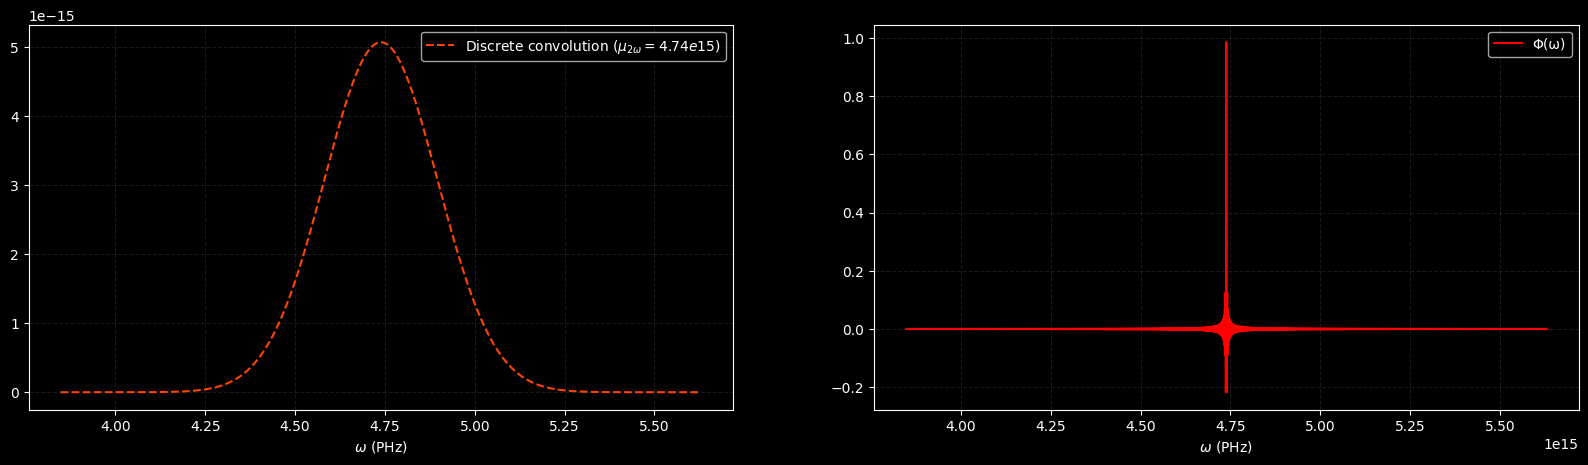

In [67]:
# --- Visualización Comparativa entrada y salida---
fig2, axs2 = plt.subplots(1,2,figsize=(20,5))

axs2[0].plot(SHG_frequencies*1e-15, conv_result, label=r'Discrete convolution ($\mu_{2\omega}=4.74e15$)', linestyle='--', color='orangered')
axs2[0].set_xlabel(r'$\omega$ (PHz)')
axs2[0].legend()
axs2[0].grid(True, linestyle='--', alpha=0.1)

axs2[1].plot(SHG_frequencies, phi, label='Φ(ω)', color='r')
axs2[1].set_xlabel(r'$\omega$ (PHz)')
axs2[1].legend()
axs2[1].grid(True, linestyle='--', alpha=0.1)



In [59]:
# product of the convolution and the phase matching function
SHG_shape = conv_result *  phi

In [60]:
begin = 4800
end = 5200

SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_shape_plot_interval = SHG_shape[begin: end]

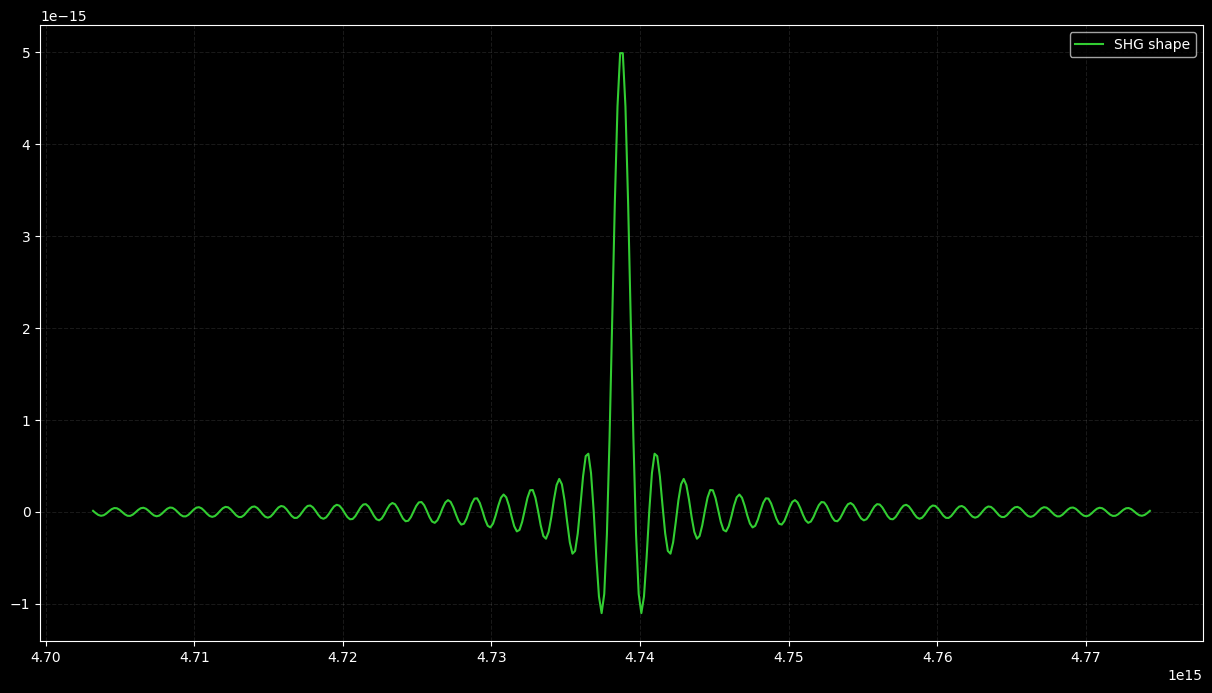

In [61]:
fig1, axs = plt.subplots(figsize=(15,8))

axs.plot(SHG_frequencies_plot_interval, SHG_shape_plot_interval, label='SHG shape', color='limegreen')
axs.legend()
axs.grid(True, linestyle='--', alpha=0.1)

# Amplitud factor
---

$$
\frac{i\omega_{0} \chi^{(2)} L}{n_{2\omega} c}G_{m}
$$

In [62]:
# at firts order Gm = 2/pi
Gm = 2/np.pi
omega_0 = fundamental_frequency
L = 4e-3  # (m) | 4 mm
c = 299792458  # (m/s)
d_eff = 15.4e-6  # (m/V) | 15.4 pm/V
chi_2 = 2 * d_eff  # (m/V) | 2 * 15.4 pm/V
n_2w = ktp.refractive_index(SHG_wavelength_um, axis='nz')


In [63]:
# Calculate the magnitude of the amplitude factor
amplitude_factor_magnitude = 1j * (Gm * omega_0 * L * chi_2) / (2 * n_2w * c)

print(f"Calculated Amplitude Factor Magnitude: {amplitude_factor_magnitude:.5e}")

Calculated Amplitude Factor Magnitude: 0.00000e+00+1.57506e-01j


In [64]:
SHG = amplitude_factor_magnitude * SHG_shape

In [65]:
SHG_intensity = np.abs(SHG_shape)**2

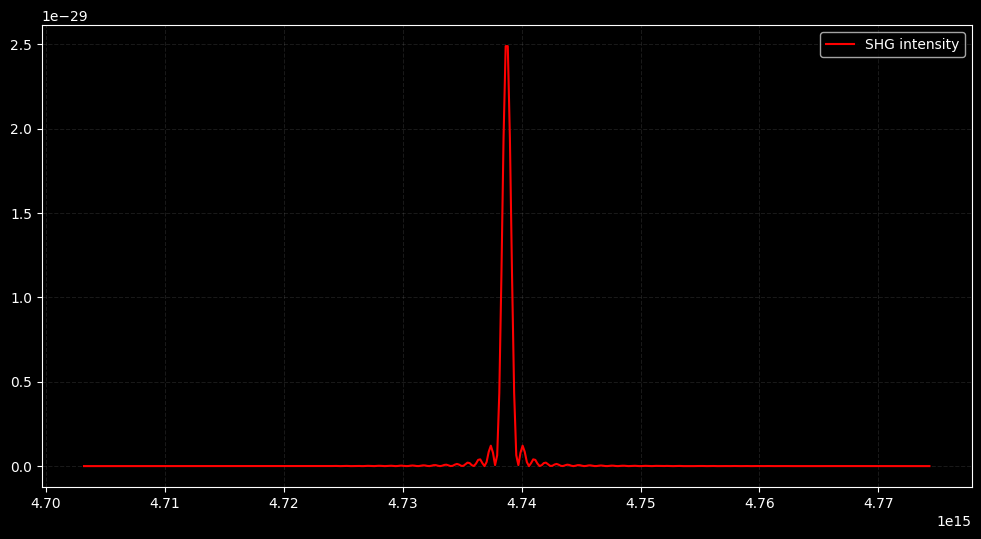

In [66]:
begin = 4800
end = 5200

SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_intensity_plot_interval = SHG_intensity[begin: end]

fig2, axs2 = plt.subplots(figsize=(12,6))

axs2.plot(SHG_frequencies_plot_interval, SHG_intensity_plot_interval, label='SHG intensity', color='red')
axs2.legend()
axs2.grid(True, linestyle='--', alpha=0.1)